# ASSESSMENT OF GOOLE ANALYTICS SESSION QUALITY METRIC

## Import libraries

In [4]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ML
from src import helpers as h
from src import visuals as v

# Load BQ and credentials
from google.cloud import bigquery
client = bigquery.Client()
%load_ext google.cloud.bigquery
import matplotlib.pyplot as plt

/Users/gunnar.griese/Desktop/python3_env/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/gunnar.griese/Desktop/python3_env/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [ ]:
!gcloud auth application-default login

In [80]:
# Run to reload external scripts
import importlib
importlib.reload(v)

<module 'src.visuals' from '/Users/gunnar.griese/Desktop/python3_env/ga-session-quality/src/visuals.py'>

## Load data

In [3]:
%%bigquery df

#standardSQL
WITH session_scope AS(
SELECT
fullVisitorId,
CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) AS session_id,
date,
EXTRACT(DAYOFWEEK FROM TIMESTAMP_SECONDS(visitStartTime)) AS day_of_week,
EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime)) AS hour_of_day,
IFNULL(totals.pageviews, 0) AS pageviews,
IFNULL(totals.hits, 0) AS hits,
channelGrouping AS channel,
IFNULL(totals.timeOnSite, 0) AS time_on_site,
IFNULL(totals.totalTransactionRevenue, 0) / 1000000 AS revenue,
IFNULL(totals.newVisits, 0) AS new_visit,
IFNULL(totals.bounces, 0) AS bounce,
device.deviceCategory AS device,
totals.sessionQualityDim/100 AS ga_pred,
IF(totals.transactions > 0, 1, 0) as transaction
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`),
    
hit_scope AS(
SELECT 
  CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) AS session_id_h,
  COUNTIF(hits.eCommerceAction.action_type = "2") AS product_detail_view,
  COUNTIF(hits.eCommerceAction.action_type = "3") AS add_to_cart,
  COUNTIF(hits.eCommerceAction.action_type = "4") AS remove_from_cart,
  COUNTIF(hits.eCommerceAction.action_type = "5") AS checkout,
  COUNTIF(hits.eCommerceAction.action_type = "6") AS purchase
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_201707*` AS GA, 
    UNNEST(GA.hits) AS hits 
GROUP BY session_id_h
)

SELECT * EXCEPT(session_id_h)
FROM session_scope AS s
LEFT JOIN hit_scope AS h
ON s.session_id = h.session_id_h

In [5]:
df.head()

,fullVisitorId,session_id,date,day_of_week,hour_of_day,pageviews,hits,channel,time_on_site,revenue,new_visit,bounce,device,ga_pred,transaction,product_detail_view,add_to_cart,remove_from_cart,checkout,purchase
0,9028717622321255428,90287176223212554281500476423,20170719,4,15,1,1,Organic Search,0,0.0,1,1,desktop,0.01,0,0,0,0,0,0
1,4881356741961388933,48813567419613889331500528371,20170719,5,5,1,1,Organic Search,0,0.0,1,1,desktop,0.01,0,0,0,0,0,0
2,5701288733574274504,57012887335742745041500510990,20170719,5,0,1,1,Organic Search,0,0.0,1,1,mobile,0.01,0,0,0,0,0,0
3,6263945464474360833,62639454644743608331500501939,20170719,4,22,1,1,Direct,0,0.0,1,1,mobile,0.01,0,0,0,0,0,0
4,2097236676736498449,20972366767364984491500484276,20170719,4,17,1,1,Display,0,0.0,1,1,desktop,0.01,0,0,0,0,0,0


In [6]:
df.describe()

,day_of_week,hour_of_day,pageviews,hits,time_on_site,revenue,new_visit,bounce,ga_pred,transaction,product_detail_view,add_to_cart,remove_from_cart,checkout,purchase
count,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,65823.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000
mean,3.941403,12.373949,3.767532,4.513118,145.820434,2.238343,0.761447,0.506990,0.042557,0.014357,0.397928,0.165153,0.026374,0.105929,0.030092
std,1.936413,6.924096,6.330727,8.813765,397.823220,112.581592,0.426202,0.499955,0.130407,0.118958,1.645290,0.985512,0.319490,0.763247,0.256808
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,13.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,18.000000,4.000000,4.000000,92.000000,0.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,23.000000,186.000000,301.000000,11316.000000,25249.260000,1.000000,1.000000,0.990000,1.000000,96.000000,49.000000,29.000000,30.000000,8.000000


## EDA

In [10]:
timeline = df.groupby("date").agg({"session_id":"count", "ga_pred":"count"}).reset_index()
timeline.columns = ["date", "sessions", "ga_predictions"]

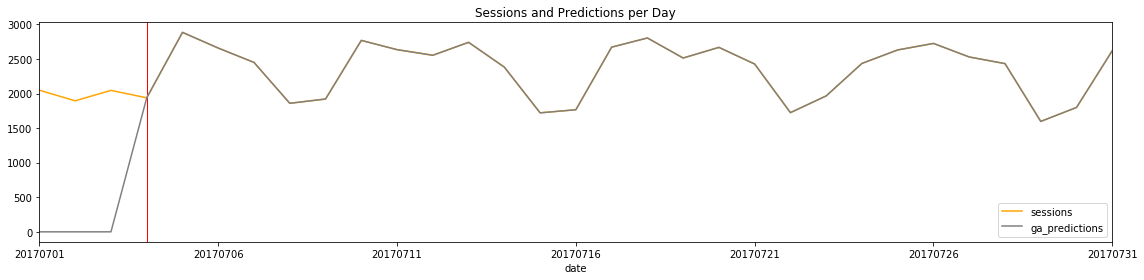

In [81]:
timeline.plot(x="date", 
              y=["sessions", "ga_predictions"], 
              figsize=(16,4), 
              title="Sessions and Predictions per Day",
             color=["orange", "grey"])
plt.axvspan(3, 3, color='red', alpha=1);
plt.tight_layout();

In [29]:
heatmap = df[['hour_of_day', 'day_of_week']].reset_index().drop(['index'], axis=1).groupby(['hour_of_day', 'day_of_week'], axis=0).size().unstack()

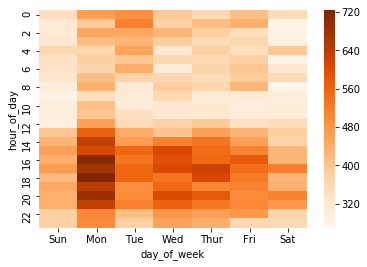

In [79]:
sns.heatmap(heatmap, cmap='Oranges', xticklabels=['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat'])

## Session Quality Accuracy

In [70]:
import importlib
importlib.reload(v)

<module 'src.visuals' from '/Users/gunnar.griese/Desktop/python3_env/ga-session-quality/src/visuals.py'>

In [39]:
df_subset = df[df["ga_pred"]>=0]
df_subset["ga_class_50"] = df_subset["ga_pred"].apply(lambda x: 1 if x >= 0.5 else 0)

/Users/gunnar.griese/Desktop/python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
df_scores, confusion_matrix, fp_value, tp_value, auc_value = h.get_error_scores(df_subset["transaction"], df_subset["ga_class_50"])

In [67]:
print("Classifier performance is as follows:")
print("------------------------------------------")
print(df_scores)
print("------------------------------------------")

Classifier performance is as follows:
------------------------------------------
   Accuracy       F1    Recall  Precision
0  0.977607  0.51321  0.771599   0.384463
------------------------------------------


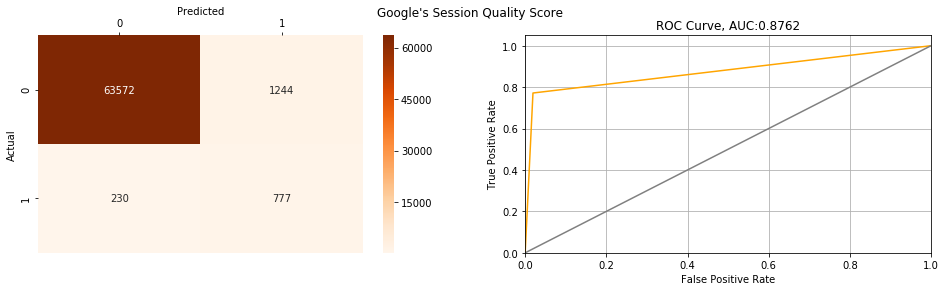

In [82]:
v.error_plots(confusion_matrix, fp_value, tp_value, auc_value)

In [47]:
auc_value

0.8762030082191875

## Identify influence factors

In [49]:
corr_df = pd.get_dummies(df_subset, columns=["channel", "device", "hour_of_day", "day_of_week"])

In [54]:
corr_df.columns

Index(['date', 'pageviews', 'hits', 'time_on_site', 'revenue', 'new_visit',
       'bounce', 'ga_pred', 'transaction', 'product_detail_view',
       'add_to_cart', 'remove_from_cart', 'checkout', 'purchase',
       'ga_class_50', 'channel_(Other)', 'channel_Affiliates',
       'channel_Direct', 'channel_Display', 'channel_Organic Search',
       'channel_Paid Search', 'channel_Referral', 'channel_Social',
       'device_desktop', 'device_mobile', 'device_tablet', 'hour_of_day_0',
       'hour_of_day_1', 'hour_of_day_2', 'hour_of_day_3', 'hour_of_day_4',
       'hour_of_day_5', 'hour_of_day_6', 'hour_of_day_7', 'hour_of_day_8',
       'hour_of_day_9', 'hour_of_day_10', 'hour_of_day_11', 'hour_of_day_12',
       'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15', 'hour_of_day_16',
       'hour_of_day_17', 'hour_of_day_18', 'hour_of_day_19', 'hour_of_day_20',
       'hour_of_day_21', 'hour_of_day_22', 'hour_of_day_23', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_we

In [61]:
corr_df = corr_df[['ga_pred', 'pageviews', 'time_on_site', 'revenue', 'new_visit',
       'bounce', 'transaction', 'product_detail_view',
       'add_to_cart', 'remove_from_cart', 'checkout', 'purchase',
       'channel_(Other)', 'channel_Affiliates',
       'channel_Direct', 'channel_Display', 'channel_Organic Search',
       'channel_Paid Search', 'channel_Referral', 'channel_Social',
       'device_desktop', 'device_mobile', 'device_tablet']]

In [62]:
#cols = ["fullVisitorId", "session_id"]
#corr_df.drop(labels=cols, axis=1, inplace=True)

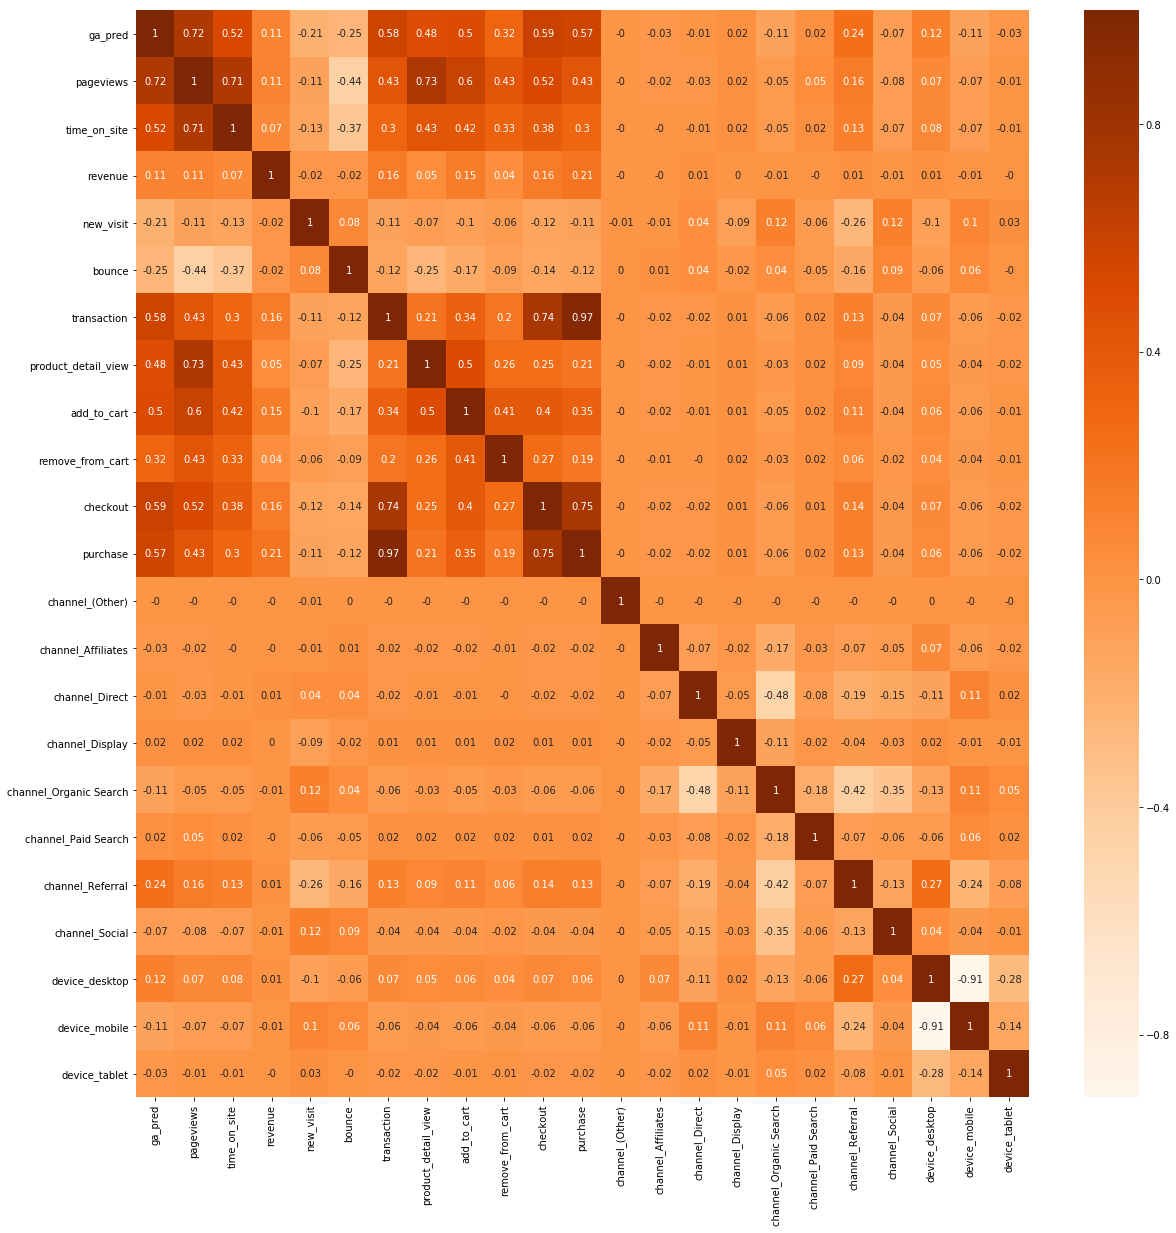

In [83]:
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_df.corr().round(2), annot=True, cmap='Oranges');
#plt.savefig("img/correlation.png")